# Определение перспективного тарифа для телеком-компании

«Мегалайн» — федеральный оператор сотовой связи. <br>
Клиентам предлагают два тарифных плана: «Смарт» и «Ультра».  <br>
В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. <br>
Коммерческий департамент хочет понять, какой тариф приносит больше денег.

## Описание тарифов
### Тариф «Смарт»
* Ежемесячная плата: 550 рублей
* Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
#### Стоимость услуг сверх тарифного пакета:
* минута разговора: 3 рубля
* сообщение: 3 рубля
* 1 Гб интернет-трафика: 200 рублей
### Тариф «Ультра»
* Ежемесячная плата: 1950 рублей
* Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
#### Стоимость услуг сверх тарифного пакета:
* минута разговора: 1 рубль
* сообщение: 1 рубль
* 1 Гб интернет-трафика: 150 рублей

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

### Шаг 1. Откроем файлы с данными и изучим общую информацию.

In [ ]:
users = pd.read_csv('/datasets/users.csv')
calls = pd.read_csv('/datasets/calls.csv')
messages = pd.read_csv('/datasets/messages.csv')
internet = pd.read_csv('/datasets/internet.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')

In [ ]:
users.info()
calls.info()
messages.info()
internet.info()
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
<class 'pandas.core.frame.D

### Шаг 2. Подготовим данные

In [ ]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y.%m.%d')
users['churn_date']= pd.to_datetime(users['churn_date'], format='%Y.%m.%d')
users = users.rename(columns={'tariff': 'tariff_name'})

calls['id'] = calls['id'].astype('int')
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y.%m.%d')
# Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
calls['duration'] = np.ceil(calls['duration']).astype('int')

messages['id'] = messages['id'].astype('int')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y.%m.%d')

internet['id'] = internet['id'].astype('int')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y.%m.%d')
internet = internet.drop(columns = ['Unnamed: 0'],axis = 1)

#### Пояснение:  

Все даты приводим к одному типу. <br>
Переименовываем столбцы для того, что бы было удобно в дальнейшем их склеивать. <br>
Меняем типы данных на столбцах id. <br>
Окрагуляем минуты. <br>
Удаляем бесполезный столбец Unnamed в датафрейме internet. <br>

### Посчитаем для каждого пользователя:

* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя;

In [ ]:
calls_total = calls.pivot_table(
    index=['user_id', pd.DatetimeIndex(calls['call_date']).month],
    values=['id','duration', 'call_date'], aggfunc={'id':'count', 'duration':'sum'}).reset_index().rename(
    columns=({'duration':'minutes_spent', 'id': 'call_count', 'call_date': 'month_number'}))

messages_total = messages.pivot_table(
    index=['user_id', pd.DatetimeIndex(messages['message_date']).month],
    values=['id', 'message_date'], aggfunc={'id':'count'}).reset_index().rename(
    columns=({'id':'messages_count', 'message_date': 'month_number'}))

internet_total = internet.pivot_table(
    index=['user_id', pd.DatetimeIndex(internet['session_date']).month],
    values=['mb_used', 'session_date'], aggfunc={'mb_used':'sum'}).reset_index().rename(
    columns=({'mb_used':'gb_used', 'session_date': 'month_number'}))

# Слияние датасетов
total = users.merge(
    messages_total, on=['user_id'], how='outer').merge(
    calls_total, on=['user_id', 'month_number'], how='outer').merge(
    internet_total, on=['user_id', 'month_number'], how='outer').merge(
    tariffs, on='tariff_name').fillna(0)

total['month_number'] = total['month_number'].astype(int)
total['messages_count'] = total['messages_count'].astype(int)
total['minutes_spent'] = total['minutes_spent'].astype(int)
total['call_count'] = total['call_count'].astype(int)
total['gb_used'] = np.ceil(total['gb_used'] / 1024).astype(int)
total['mb_per_month_included'] = np.ceil(total['mb_per_month_included'] / 1024).astype(int)

# Считаем выручку по новому (я умею писать функции, даже могу лямбду забацать, но в функции тут смысла нету)
# должно быстро работать потому что я сохранил операции со столбцами.
total['revenue'] = total['rub_monthly_fee']
for param, included, per in zip(['minutes_spent', 'messages_count', 'gb_used'],
                                ['minutes_included', 'messages_included', 'mb_per_month_included'],
                                ['rub_per_minute', 'rub_per_message', 'rub_per_gb']):
    tmp = (total[param] - total[included]) * total[per]
    tmp[tmp < 0] = 0
    total['revenue'] += tmp

# Удаляем не нужные столбцы
total = total.drop(columns=['messages_included', 'mb_per_month_included',
                            'minutes_included', 'rub_per_gb',
                            'rub_per_message', 'rub_per_minute'])

### Шаг 3. Проанализируем данные

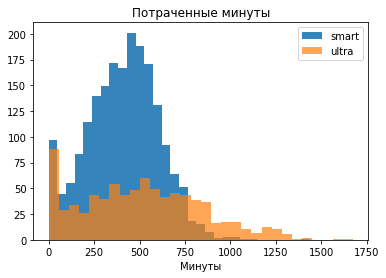

In [ ]:
plt.hist(total.query('tariff_name == "smart"')['minutes_spent'], alpha = 0.9, bins = 30)
plt.hist(total.query('tariff_name == "ultra"')['minutes_spent'], alpha = 0.7, bins = 30)
plt.legend(['smart', 'ultra'])
plt.title('Потраченные минуты')
plt.xlabel('Минуты')
plt.show()

Проанализировав потраченные минуты на каждом тарифе можно сделать выводы:
1. Довольно много пользователей вообще не тратят минуты (видимо им нужны смс или гб)
2. Пользователям тарифа SMART требуется в среднем от 250 до 750 минут в месяц.
3. Пользователям тарифа ULTRA требуется в среднем от 50 до 1000 минут в месяц.

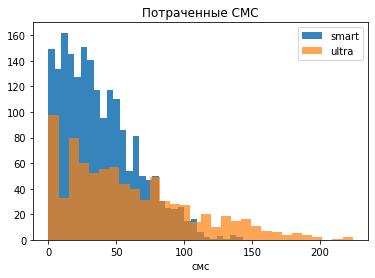

In [ ]:
plt.hist(total.query('tariff_name == "smart"')['messages_count'], alpha = 0.9, bins = 30)
plt.hist(total.query('tariff_name == "ultra"')['messages_count'], alpha = 0.7, bins = 30)
plt.legend(['smart', 'ultra'])
plt.title('Потраченные СМС')
plt.xlabel('смс')
plt.show()

Проанализировав потраченные сообщения на каждом тарифе можно сделать выводы:
1. Довольно много пользователей вообще не тратят минуты (видимо им нужны минуты или гб)
2. Пользователям тарифа SMART требуется в среднем от 10 до 70 сообщений в месяц.
3. Пользователям тарифа ULTRA требуется в среднем от 20 до 150 сообщений в месяц.

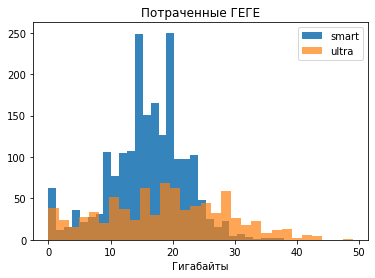

In [ ]:
plt.hist(total.query('tariff_name == "smart"')['gb_used'], alpha = 0.9, bins = 30)
plt.hist(total.query('tariff_name == "ultra"')['gb_used'], alpha = 0.7, bins = 30)
plt.legend(['smart', 'ultra'])
plt.title('Потраченные ГЕГЕ')
plt.xlabel('Гигабайты')
plt.show()

Проанализировав потраченные гигабайты на каждом тарифе можно сделать выводы:
1. Пользователям тарифа SMART требуется в среднем от 10 до 25 гб в месяц.
3. Пользователям тарифа ULTRA требуется в среднем от 10 до 30 гб в месяц.

#### Посчитаем среднее количество, дисперсию и стандартное отклонение выручки.

In [ ]:
total.pivot_table(index='tariff_name', values= ['revenue', 'minutes_spent', 'messages_count', 'gb_used'],
                  aggfunc= ['mean', 'var','std'])


mean                                                  var  \
               gb_used messages_count minutes_spent      revenue    gb_used   
tariff_name                                                                   
smart        15.946728      37.753932    409.097920  1270.851344  37.900206   
ultra        18.806098      59.296341    513.384146  2044.756098  99.362844   

                                                               std  \
            messages_count  minutes_spent        revenue   gb_used   
tariff_name                                                          
smart           736.102364   39110.953351  672056.034236  6.156314   
ultra          2155.964578  110695.125756  105021.307960  9.968091   

                                                      
            messages_count minutes_spent     revenue  
tariff_name                                           
smart            27.131206    197.764894  819.790238  
ultra            46.432366    332.708770  324.069912

### Шаг 4. Проверим гипотизы.

#### Первая гипотиза
Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются; <br>
Нулевая гипотиза звучит так: <br>
Средние двух генеральных совокупностей (тарифов) равны между собой <br>
Если уровень значимости выше, чем P-value, значит что нулевая гипотиза будет отвергнута <br>

In [ ]:
alpha = .05

results = st.ttest_ind(
    total.query('tariff_name == "smart"')['revenue'],
    total.query('tariff_name == "ultra"')['revenue'])

if alpha > results.pvalue:
    print('Нулевая гипотеза отвергнута')
else: print('Нулевую гипотизу не получилось отвергнуть')


Нулевая гипотеза отвергнута


Судя по данным средняя выручка различается.

#### Вторая гипотиза
Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. <br>
Нулевая гипотиза звучит так: <br>
Средняя выручка двух генеральных совокупностей (Москвы и регионов) равны между собой <br>
Если уровень значимости выше, чем P-value, значит что нулевая гипотиза будет отвергнута <br>

In [ ]:

alpha = .05

results = st.ttest_ind(
    total.query('city == "Москва"')['revenue'],
    total.query('city != "Москва"')['revenue'])

if alpha > results.pvalue:
    print('Нулевая гипотеза отвергнута')
else: print('Нулевую гипотизу не получилось отвергнуть')





Нулевую гипотизу не получилось отвергнуть


Судя по данным средняя выручка москвичей не отличается от средней выручки россиян.

#### Пояснение

1. Как я формулировали нулевую и альтернативную гипотезы? <br>
Очень просто, как учили. <br>
2. Какой критерий использовали для проверки гипотез и почему?<br>
Тут тоже все просто, критерий всего 1- альфа общепринятая .01 или .05. Почему? Ну потому что.

### Шаг 5. Общий вывод.

В общем было интересно. <br>
Мы обработали данные, посчитали выручку на каждого пользователя, построили гистраграммы, убедились что оба тарифа хороши. <br>
Проанализировав потраченные минуты, сообщений и гигабайты на каждом тарифе можно сделать выводы:
1. Довольно много пользователей вообще не тратят минуты (видимо им нужны смс или гб)
2. Пользователям тарифа SMART требуется в среднем от 250 до 750 минут в месяц.
3. Пользователям тарифа ULTRA требуется в среднем от 50 до 1000 минут в месяц.
1. Довольно много пользователей вообще не тратят минуты (видимо им нужны минуты или гб)
2. Пользователям тарифа SMART требуется в среднем от 10 до 70 сообщений в месяц.
3. Пользователям тарифа ULTRA требуется в среднем от 20 до 150 сообщений в месяц.
1. Пользователям тарифа SMART требуется в среднем от 10 до 25 гб в месяц.
3. Пользователям тарифа ULTRA требуется в среднем от 10 до 30 гб в месяц.
<br><br>
Посчитали статистические показатели, для пользователей тарифа СМАРТ в среднем требуется на 1 гб больше интернета, чем есть в пакете. <br>
Средняя выручка тарифов различается, в среднем пользователи тарифа СМАРТ переплачивают в 2,5 раза, больше всего за интернет. <br>
Выручка москвичей от Россиян в целом не различается. <br>
Тариф СМАРТ лучше потому что пользователь пусть и переплачивает, но это все равно выгоднее тарифа УЛЬТРА и у тарифа СМАРТ хороший потенциал для рекламы за счет его дешевой стоимости. Скорее всего этим тарифом пользуется большинство пользователей. <br>